Generate plots based on parametric dataset (compare 4 methods - two full signal and two trial-based):
* % of failed estimates (failed estimation and negative R-squared)
* ACF decline in specific range
* CI: 0 in the interval, width?
* R-squared (on unit level and as %)

Inclusion criteria:
* non zero bins
* 1 hz of activity
* R-squared > 0.5

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
#dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\fig2_3_4a\\'
results_folder = project_folder_path + 'results\\mice\\dataset\\cut_30min\\'

fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\inclusion\\'

In [19]:
save_fig = True

### Load data

In [4]:
units_info_df = pd.read_pickle(results_folder + 'lv_df.pkl')
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym', 'fr_hz_spont_30min', 'lv']].copy()
units_info_df_subset['fr_hz_spont_30min_log10'] = np.log10(units_info_df_subset['fr_hz_spont_30min'])

alphas = units_info_df_subset['lv'].values
fr_values = units_info_df_subset['fr_hz_spont_30min'].values

print(f'len units_info_df_subset {len(units_info_df_subset)}')
units_info_df_subset.head(5)

len units_info_df_subset 5775


,unit_id,ecephys_structure_acronym,fr_hz_spont_30min,lv,fr_hz_spont_30min_log10
0,950913540,VISam,6.038333,1.239003,0.780917
1,950915005,VISam,4.030556,0.628989,0.605365
2,950915018,VISam,1.903333,0.557600,0.279515
3,950913798,VISam,1.045556,0.683688,0.019347
4,950915049,VISam,0.953889,1.125211,-0.020502


In [5]:
with open(results_folder + 'non_binned\\acf_isttc_full_50ms_20lags_dict_25dt.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(results_folder + 'binned\\acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'binned\\pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'non_binned\\sttc_trial_concat_50ms_20lags_dict_25dt.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 5775
len acf_full_dict 5775
len pearsonr_trial_avg_dict 5775
len sttc_trial_concat_dict 5775


### Make summary dfs

In [6]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

def get_trials_plot_df(trial_dict_, method_, alphas_, fr_values_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[0] # take the first trials realization
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'tau_lower': tau_dict['tau_lower'],
                'tau_upper': tau_dict['tau_upper'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'acf_decline': calculate_acf_decline_flag(acf_array, start_idx=1, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    df['fr'] = fr_values_
    df['alpha'] = alphas_

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}, method {method_}')

    return df

def get_full_plot_df(trial_dict_, method_, alphas_, fr_values_):
    data = []
    for unit_id, unit_data in trial_dict_.items():
        taus = unit_data['taus']  
        data.append({
            'unit_id': unit_id,
            'tau': taus['tau'],
            'tau_lower': taus['tau_lower'],
            'tau_upper': taus['tau_upper'],
            'fit_r_squared': taus['fit_r_squared'],
            'acf_decline': calculate_acf_decline_flag(unit_data['acf'], start_idx=1, end_idx=4),
            'method': method_,
        })
    df = pd.DataFrame(data)
    df['tau_ms'] = df['tau'] * 50
    
    df['fr'] = fr_values_
    df['alpha'] = alphas_

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}, method {method_}')

    return df

In [7]:
# for trial based measures one realization of trials is taken
random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)

pearsontr_trial_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', alphas, fr_values, random_trials_impl)
isttc_trial_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', alphas, fr_values, random_trials_impl)
isttc_full_plot_df = get_full_plot_df(isttc_full_dict, 'isttc_full', alphas, fr_values)
acf_full_plot_df = get_full_plot_df(acf_full_dict, 'acf_full', alphas, fr_values)

N rows with NaNs 995, method pearsonr_trial_avg


In [8]:
tau_plot_all_long_df = pd.concat([acf_full_plot_df, 
                                  isttc_full_plot_df, 
                                  pearsontr_trial_plot_df, 
                                  isttc_trial_plot_df])
tau_plot_all_long_df.reset_index(inplace=True, drop=True)

tau_plot_all_long_df['ci_zero_excluded'] = (
    (tau_plot_all_long_df['tau_lower'] > 0) | (tau_plot_all_long_df['tau_upper'] < 0)
).astype(int)

tau_plot_all_long_df['ci_width'] = np.where(
    tau_plot_all_long_df['ci_zero_excluded'] == 1,
    tau_plot_all_long_df['tau_upper'] - tau_plot_all_long_df['tau_lower'],
    np.nan
)

tau_plot_all_long_df['ci_width_ms'] = tau_plot_all_long_df['ci_width'] * 50
tau_plot_all_long_df['fr_log10'] = np.log10(tau_plot_all_long_df['fr'])

print(f'len tau_plot_long_df {len(tau_plot_all_long_df)}')
print(tau_plot_all_long_df.keys())
tau_plot_all_long_df.head(3)

len tau_plot_long_df 23100
Index(['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared',
       'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'ci_zero_excluded',
       'ci_width', 'ci_width_ms', 'fr_log10'],
      dtype='object')


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,fr,alpha,ci_zero_excluded,ci_width,ci_width_ms,fr_log10
0,950913540,0.580319,0.336549,0.824088,9.361658e-01,False,acf_full,29.015926,6.038333,1.239003,1,0.487539,24.37695,0.780917
1,950915005,0.034201,0.034201,0.034201,-5.534868e-10,False,acf_full,1.710055,4.030556,0.628989,1,0.000000,0.00000,0.605365
2,950915018,0.037646,0.037646,0.037646,-2.423335e-10,False,acf_full,1.882284,1.903333,0.557600,1,0.000000,0.00000,0.279515


### Plot overlall stats (without within unit comparison)

In [9]:
print(f'alphas min {np.min(alphas)}, max {np.max(alphas)}')
print(f'alphas min {np.min(fr_values)}, max {np.max(fr_values)}')

alphas min 0.14437662231160867, max 2.155585778985039
alphas min 0.02388888888888889, max 73.93388888888889


In [10]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2'
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]
color_trails = ['black', color_pearson_trail_avg, color_sttc_trail_concat] # black is when both method failed

#### % of failed estimates (failed estimation and negative R-squared)

In [ ]:
def compute_exclusion(group):
    tau_nans = group['tau'].isna().sum()
    fit_r_squared_neg = (group['fit_r_squared'] < 0).sum()
    either_issue = ((group['tau'].isna()) | (group['fit_r_squared'] < 0)).sum()
    total = len(group)
    percent_tau_nans = 100 * tau_nans / total if total > 0 else 0
    percent_fit_r_squared_neg = 100 * fit_r_squared_neg / total if total > 0 else 0
    percent_either_issue = 100 * either_issue / total if total > 0 else 0
    return pd.Series({
        'tau_nans': tau_nans,
        'fit_r_squared_neg': fit_r_squared_neg,
        'exclusion': either_issue,
        'percent_tau_nans': percent_tau_nans,
        'percent_fit_r_squared_neg': percent_fit_r_squared_neg,
        'exclusion_perc': percent_either_issue
    })

exclusion_df = tau_plot_all_long_df.groupby('method').apply(compute_exclusion).reset_index()
exclusion_df

In [ ]:
diff_trial_methods = exclusion_df.query('method == "pearsonr_trial_avg"')['exclusion'].values[0] - exclusion_df.query('method == "sttc_trial_concat"')['exclusion'].values[0]
diff_trial_methods

In [ ]:
diff_trial_methods = exclusion_df.set_index('method').loc['pearsonr_trial_avg', 'exclusion'] - \
                     exclusion_df.set_index('method').loc['sttc_trial_concat', 'exclusion']
diff_trial_methods_perc = exclusion_df.set_index('method').loc['pearsonr_trial_avg', 'exclusion_perc'] - \
                     exclusion_df.set_index('method').loc['sttc_trial_concat', 'exclusion_perc']
print(f'diff_trial_methods {diff_trial_methods}, diff_trial_methods_perc {diff_trial_methods_perc}')

In [ ]:
methods = exclusion_df['method']
x = np.arange(len(methods))

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, exclusion_df['percent_tau_nans'], label='Failed fit')
axes.bar(x, exclusion_df['percent_fit_r_squared_neg'], bottom=exclusion_df['percent_tau_nans'], label='Negative R-squared')
axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'Excluded fits, diff % {diff_trial_methods_perc:.2f}, diff units {diff_trial_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
axes.set_yticks([0,10,20,30, 40])

total = exclusion_df['exclusion_perc']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_plot.svg' , bbox_inches='tight')

In [ ]:
nans_neg_r2_df = tau_plot_all_long_df.query('tau.isna() or fit_r_squared < 0')[['unit_id', 'method', 'fr', 'fr_log10', 'alpha']].copy()
print(nans_neg_r2_df.keys())
nans_neg_r2_df

##### For which units methods fail? (in general)

nans_neg_r2_df without duplicates

In [ ]:
nans_neg_r2_df_unique_df = nans_neg_r2_df.drop_duplicates(subset='unit_id')
nans_neg_r2_df_unique_df = nans_neg_r2_df_unique_df.drop_duplicates(subset='unit_id').reset_index(drop=True)

method_counts = nans_neg_r2_df.groupby('unit_id').size().rename('n_methods')
nans_neg_r2_df_unique_df = nans_neg_r2_df_unique_df.merge(method_counts, on='unit_id')
nans_neg_r2_df_unique_df

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a new colormap based on cmap but only sampling its colors
    between minval and maxval (both in [0,1]).
    """
    new_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap.name}_trunc_{minval:.2f}_{maxval:.2f}",
        new_colors
    )
    return new_cmap

trunc_magma = truncate_colormap(plt.cm.magma, minval=0.15, maxval=1)

fig, axes = plt.subplots(1,1, figsize=(4,2.5))

hb0 = axes.hexbin(
    x=nans_neg_r2_df_unique_df['fr'], y=nans_neg_r2_df_unique_df['alpha'],
    gridsize=10,                
    cmap=trunc_magma           
)

axes.set_xlabel('Firing rate (hz)')
axes.set_ylabel('LV (a.u.)')

vmin = np.min([hb0.get_array().min()])
vmax = np.max([hb0.get_array().max()])
print(vmin, vmax)
hb0.set_clim(vmin, vmax)
fig.colorbar(hb0, ax=axes, shrink=1)

fig.suptitle(f'Excluded fits', y=1.05)
    
   #ax.set_ylim([0.1, 0.9])
   # ax.set_yticks(np.linspace(0.1, 0.9, 5))

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params.svg' , bbox_inches='tight')

In [ ]:
trunc_magma = truncate_colormap(plt.cm.magma, minval=0.15, maxval=1)

fig, axes = plt.subplots(1,1, figsize=(4,2.5))

hb0 = axes.hexbin(
    x=nans_neg_r2_df_unique_df['fr_log10'], y=nans_neg_r2_df_unique_df['alpha'],
    gridsize=10,                
    cmap=trunc_magma           
)

axes.set_xlabel('Firing rate log10 (hz)')
axes.set_ylabel('LV (a.u.)')

vmin = np.min([hb0.get_array().min()])
vmax = np.max([hb0.get_array().max()])
print(vmin, vmax)
hb0.set_clim(vmin, vmax)
fig.colorbar(hb0, ax=axes, shrink=1)

fig.suptitle(f'Excluded fits', y=1.05)
    
   #ax.set_ylim([0.1, 0.9])
#axes.set_xticks(np.linspace(np.min(nans_neg_r2_df_unique_df['fr_log10'].values), np.max(nans_neg_r2_df_unique_df['fr_log10'].values), 5))

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_fr_log.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_fr_log.svg' , bbox_inches='tight')

##### For which units methods fail? (methods specific)

nans_neg_r2_df 

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(4,3))

sns.scatterplot(ax=axes, x='fr', y='alpha', hue='method', data=nans_neg_r2_df, s=5, alpha=0.5, palette=colors, legend=True)

axes.set_xlabel('Firing rate (hz)')
axes.set_ylabel('Lv (a.u.)')

axes.legend(bbox_to_anchor=(0.95, 1.25), ncol=2, frameon=False, markerscale=6)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_method_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_method_scatter.svg' , bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(4,1, figsize=(3,10), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.scatterplot(ax=axes[0], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 4'), s=5, alpha=1, legend=False)

sns.scatterplot(ax=axes[1], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 3'), s=5, alpha=1, legend=False)

sns.scatterplot(ax=axes[2], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 2'), s=5, alpha=1, legend=False)

sns.scatterplot(ax=axes[3], x='fr', y='alpha', data=nans_neg_r2_df_unique_df.query('n_methods == 1'), s=5, alpha=1, legend=False)

axes[0].set_title('4 methods failed')
axes[1].set_title('3 methods failed')
axes[2].set_title('2 methods failed')
axes[3].set_title('1 methods failed')

for ax in axes.flat:
    ax.set_ylabel('Excitation strength (a.u.)')
    ax.set_xlabel('')
    
axes[3].set_xlabel('Firing rate (hz)')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_n_methods_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_n_methods_scatter.svg' , bbox_inches='tight')

In [ ]:
nans_neg_r2_df_trials = nans_neg_r2_df[nans_neg_r2_df['method'].isin(['pearsonr_trial_avg', 'sttc_trial_concat'])]
nans_neg_r2_df_trials.reset_index(inplace=True, drop=True)
method_counts = nans_neg_r2_df_trials.groupby('unit_id')['method'].nunique()
both_methods = method_counts[method_counts == 2].index

# Count
num_both = len(both_methods)
print(f"Number of units with both methods: {num_both}")

In [ ]:
method1 = "pearsonr_trial_avg"
method2 = "sttc_trial_concat"

def detect_failed_methods(methods):
    methods_set = set(methods)
    if method1 in methods_set and method2 in methods_set:
        return "both"
    elif method1 in methods_set:
        return method1
    elif method2 in methods_set:
        return method2
    else:
        return "none"  # just in case, this shouldn't happen

failed_methods = nans_neg_r2_df_trials.groupby('unit_id')['method'].apply(detect_failed_methods).rename('failed_methods')
# Take one row per unit_id (e.g., the first), and merge in the failed_methods info
nans_neg_r2_df_trials_unique = nans_neg_r2_df_trials.drop_duplicates(subset='unit_id').merge(failed_methods, on='unit_id')

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(
    data=nans_neg_r2_df_trials_unique, 
    x='fr', 
    hue='failed_methods', 
    hue_order=['both', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(np.min(fr_values), np.max(fr_values)),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=True,
    ax=axes[0]
)

sns.kdeplot(
    data=nans_neg_r2_df_trials_unique, 
    x='alpha', 
    hue='failed_methods', 
    hue_order=['both', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(np.min(alphas), np.max(alphas)),
    common_norm=True,  
    fill=False,
    palette=color_trails,
    legend=False,
    ax=axes[1]
)

axes[0].set_xlabel('Firing rate (hz)')
axes[1].set_xlabel('Lv (a.u.)')

# axes[0].set_xticks(np.linspace(0, 10, 5))
# axes[1].set_xticks(np.linspace(0.1, 0.9, 5))

axes[0].set_xlim([np.min(fr_values), np.max(fr_values)])
axes[1].set_xlim([np.min(alphas), np.max(alphas)])

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_scatter.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_scatter.svg' , bbox_inches='tight')

In [ ]:
bins = 10
fr_bins = np.linspace(np.min(fr_values), np.max(fr_values), bins + 1)
alpha_bins = np.linspace(np.min(alphas), np.max(alphas), bins + 1)

hist1, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['fr'], 
                             nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['alpha'], 
                             bins=[fr_bins, alpha_bins])
hist2, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['fr'], 
                             nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['alpha'], 
                             bins=[fr_bins, alpha_bins])
hist_diff = hist2 - hist1

plot_limits = np.max([np.abs(hist_diff.min()), 
                     np.abs(hist_diff.max())])
print(plot_limits)


fig, axes = plt.subplots(1, 1, figsize=(5, 4))

norm = TwoSlopeNorm(vcenter=0, vmin=-plot_limits, vmax=plot_limits)

sns.heatmap(hist_diff.T, ax=axes, cmap="RdBu_r", norm=norm, cbar=True)
axes.set_title("iSTTC fails - PearsonR fails")
axes.invert_yaxis()

axes.set_xlabel('Firing rate log10 (hz)')
axes.set_ylabel('Lv (a.u.)')

axes.set_yticklabels([])
axes.set_xticklabels([])

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_hist.svg' , bbox_inches='tight')

In [ ]:
bins = 10
fr_bins = np.linspace(np.min(nans_neg_r2_df_trials['fr_log10'].values), np.max(nans_neg_r2_df_trials['fr_log10'].values), bins + 1)
alpha_bins = np.linspace(np.min(alphas), np.max(alphas), bins + 1)

hist1, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['fr_log10'], 
                             nans_neg_r2_df_trials.query('method == "pearsonr_trial_avg"')['alpha'], 
                             bins=[fr_bins, alpha_bins])
hist2, _, _ = np.histogram2d(nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['fr_log10'], 
                             nans_neg_r2_df_trials.query('method == "sttc_trial_concat"')['alpha'], 
                             bins=[fr_bins, alpha_bins])
hist_diff = hist2 - hist1

plot_limits = np.max([np.abs(hist_diff.min()), 
                     np.abs(hist_diff.max())])
print(plot_limits)


fig, axes = plt.subplots(1, 1, figsize=(5, 4))

norm = TwoSlopeNorm(vcenter=0, vmin=-plot_limits, vmax=plot_limits)

sns.heatmap(hist_diff.T, ax=axes, cmap="RdBu_r", norm=norm, cbar=True)
axes.set_title("iSTTC fails - PearsonR fails")
axes.invert_yaxis()

axes.set_xlabel('Firing rate (hz)')
axes.set_ylabel('Lv (a.u.)')

# axes.set_yticklabels([])
# axes.set_xticklabels([])

sns.despine()

# if save_fig:
#     plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_hist_fr_log10.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'excluded_fits_vs_3params_per_methods_trial_hist_fr_log10.svg' , bbox_inches='tight')

In [ ]:
fr_bins

#### ACF decline and CI without zero

In [11]:
included_df = tau_plot_all_long_df.query('tau.notna() and fit_r_squared >= 0').copy()
included_df.groupby(by='method', as_index=False).count()

,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,tau_ms,fr,alpha,ci_zero_excluded,ci_width,ci_width_ms,fr_log10
0,acf_full,4561,4561,4561,4561,4561,4561,4561,4561,4561,4561,3890,3890,4561
1,isttc_full,4485,4485,4485,4485,4485,4485,4485,4485,4485,4485,3822,3822,4485
2,pearsonr_trial_avg,3430,3430,3430,3430,3430,3430,3430,3430,3430,3430,614,614,3430
3,sttc_trial_concat,4143,4143,4143,4143,4143,4143,4143,4143,4143,4143,820,820,4143


In [12]:
acf_decline_df = included_df.groupby('method').agg(
    num_true=('acf_decline', lambda x: x.sum())
).assign(
    total=len(units_info_df_subset),
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
acf_decline_df

,method,num_true,total,percent_true
0,acf_full,3086,5775,53.437229
1,isttc_full,2976,5775,51.532468
2,pearsonr_trial_avg,1482,5775,25.662338
3,sttc_trial_concat,1787,5775,30.943723


diff_acf_methods -305, diff_acf_methods_perc -5.28138528138528


C:\Users\ipochino\AppData\Local\Temp\ipykernel_18512\4261753614.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend(frameon = False)


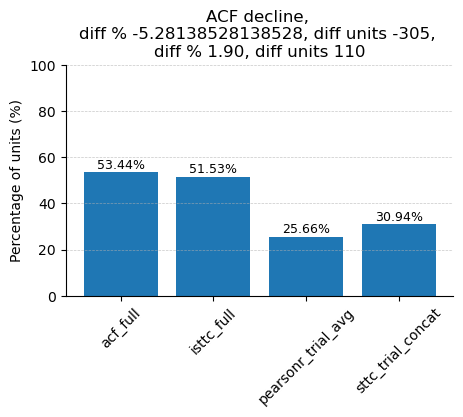

In [13]:
methods = acf_decline_df['method']
x = np.arange(len(methods))

diff_acf_methods = acf_decline_df.set_index('method').loc['pearsonr_trial_avg', 'num_true'] - \
                     acf_decline_df.set_index('method').loc['sttc_trial_concat', 'num_true']
diff_acf_methods_perc = acf_decline_df.set_index('method').loc['pearsonr_trial_avg', 'percent_true'] - \
                     acf_decline_df.set_index('method').loc['sttc_trial_concat', 'percent_true']
print(f'diff_acf_methods {diff_acf_methods}, diff_acf_methods_perc {diff_acf_methods_perc}')

diff_acf_full_methods = acf_decline_df.set_index('method').loc['acf_full', 'num_true'] - \
                     acf_decline_df.set_index('method').loc['isttc_full', 'num_true']
diff_acf_full_methods_perc = acf_decline_df.set_index('method').loc['acf_full', 'percent_true'] - \
                     acf_decline_df.set_index('method').loc['isttc_full', 'percent_true']

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, acf_decline_df['percent_true'], label='')

axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'ACF decline, \ndiff % {diff_acf_methods_perc}, diff units {diff_acf_methods}, \ndiff % {diff_acf_full_methods_perc:.2f}, diff units {diff_acf_full_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
#axes.set_yticks([0,5,10,15,20])
axes.set_ylim([0, 100])

total = acf_decline_df['percent_true']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'acf_decline_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'acf_decline_plot.svg' , bbox_inches='tight')

In [14]:
ci_zero_df = included_df.groupby('method').agg(
    num_true=('ci_zero_excluded', lambda x: x.sum())
).assign(
    total=len(units_info_df_subset),
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
ci_zero_df

,method,num_true,total,percent_true
0,acf_full,3890,5775,67.359307
1,isttc_full,3822,5775,66.181818
2,pearsonr_trial_avg,614,5775,10.632035
3,sttc_trial_concat,820,5775,14.199134


diff_acf_methods -206, diff_acf_methods_perc -3.567099567099568


C:\Users\ipochino\AppData\Local\Temp\ipykernel_18512\1996577762.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend(frameon = False)


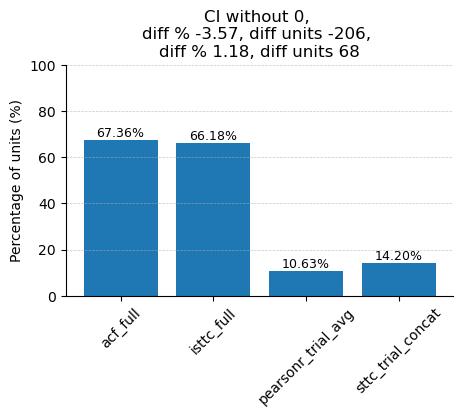

In [15]:
methods = acf_decline_df['method']
x = np.arange(len(methods))

diff_acf_methods = ci_zero_df.set_index('method').loc['pearsonr_trial_avg', 'num_true'] - \
                     ci_zero_df.set_index('method').loc['sttc_trial_concat', 'num_true']
diff_acf_methods_perc = ci_zero_df.set_index('method').loc['pearsonr_trial_avg', 'percent_true'] - \
                     ci_zero_df.set_index('method').loc['sttc_trial_concat', 'percent_true']
print(f'diff_acf_methods {diff_acf_methods}, diff_acf_methods_perc {diff_acf_methods_perc}')

diff_acf_full_methods = ci_zero_df.set_index('method').loc['acf_full', 'num_true'] - \
                     ci_zero_df.set_index('method').loc['isttc_full', 'num_true']
diff_acf_full_methods_perc = ci_zero_df.set_index('method').loc['acf_full', 'percent_true'] - \
                     ci_zero_df.set_index('method').loc['isttc_full', 'percent_true']

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, ci_zero_df['percent_true'], label='')

axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'CI without 0, \ndiff % {diff_acf_methods_perc:.2f}, diff units {diff_acf_methods}, \ndiff % {diff_acf_full_methods_perc:.2f}, diff units {diff_acf_full_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
#axes.set_yticks([0,5,10,15,20])
axes.set_ylim([0, 100])

total = ci_zero_df['percent_true']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'ci_no_zero_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'ci_no_zero_plot.svg' , bbox_inches='tight')

#### R-squared > 0.5

In [16]:
fit_r2_df = included_df.groupby('method').agg(
    num_true=('fit_r_squared', lambda x: (x >= 0.5).sum())
).assign(
    total=len(units_info_df_subset),
    percent_true=lambda x: 100 * x['num_true'] / x['total']
).reset_index()
fit_r2_df

,method,num_true,total,percent_true
0,acf_full,4436,5775,76.813853
1,isttc_full,4351,5775,75.341991
2,pearsonr_trial_avg,1523,5775,26.372294
3,sttc_trial_concat,1792,5775,31.030303


diff_acf_methods -269, diff_acf_methods_perc -4.658008658008658


C:\Users\ipochino\AppData\Local\Temp\ipykernel_18512\2299156503.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend(frameon = False)


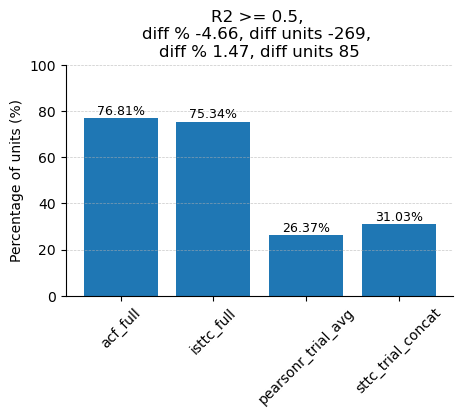

In [17]:
methods = acf_decline_df['method']
x = np.arange(len(methods))

diff_acf_methods = fit_r2_df.set_index('method').loc['pearsonr_trial_avg', 'num_true'] - \
                     fit_r2_df.set_index('method').loc['sttc_trial_concat', 'num_true']
diff_acf_methods_perc = fit_r2_df.set_index('method').loc['pearsonr_trial_avg', 'percent_true'] - \
                     fit_r2_df.set_index('method').loc['sttc_trial_concat', 'percent_true']
print(f'diff_acf_methods {diff_acf_methods}, diff_acf_methods_perc {diff_acf_methods_perc}')

diff_acf_full_methods = fit_r2_df.set_index('method').loc['acf_full', 'num_true'] - \
                     fit_r2_df.set_index('method').loc['isttc_full', 'num_true']
diff_acf_full_methods_perc = fit_r2_df.set_index('method').loc['acf_full', 'percent_true'] - \
                     fit_r2_df.set_index('method').loc['isttc_full', 'percent_true']

fig, axes = plt.subplots(1,1, figsize=(5,3))

axes.bar(x, fit_r2_df['percent_true'], label='')

axes.set_xticks(x, methods, rotation=45)
axes.set_ylabel('Percentage of units (%)')
axes.set_title(f'R2 >= 0.5, \ndiff % {diff_acf_methods_perc:.2f}, diff units {diff_acf_methods}, \ndiff % {diff_acf_full_methods_perc:.2f}, diff units {diff_acf_full_methods}')
axes.legend(frameon = False)
axes.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
#axes.set_yticks([0,5,10,15,20])
axes.set_ylim([0, 100])

total = fit_r2_df['percent_true']
for i, (xi, height) in enumerate(zip(x, total)):
    axes.text(xi, height + 0.3, f"{height:.2f}%", ha='center', va='bottom', fontsize=9)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'r2_more_0_5_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_more_0_5_plot.svg' , bbox_inches='tight')

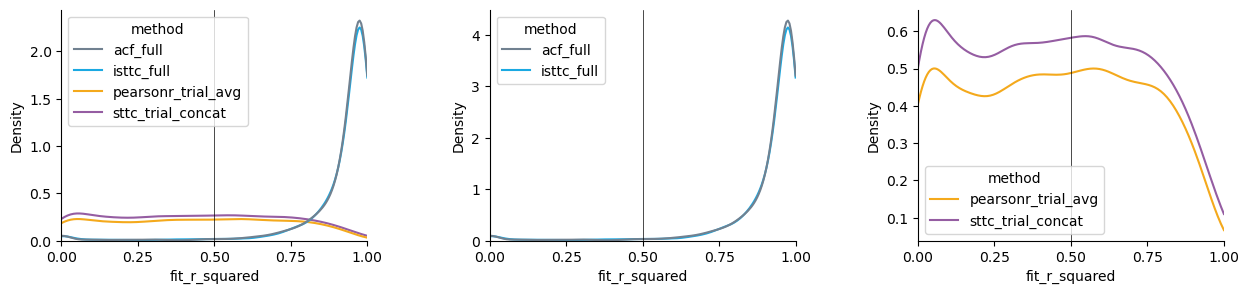

In [20]:
# R2 as KDE plots

fig, axes = plt.subplots(1,3, figsize=(15,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(
    data=included_df, 
    x='fit_r_squared', 
    hue='method', 
    hue_order=['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(0, 1),
    common_norm=True,  
    fill=False,
    palette=colors,
    legend=True,
    ax=axes[0]
)

sns.kdeplot(
    data=included_df.query('method == "acf_full" or method == "isttc_full"'), 
    x='fit_r_squared', 
    hue='method', 
    hue_order=['acf_full', 'isttc_full'],    
    clip=(0, 1),
    common_norm=True,  
    fill=False,
    palette=[color_acf_full, color_isttc_full],
    legend=True,
    ax=axes[1]
)

sns.kdeplot(
    data=included_df.query('method == "pearsonr_trial_avg" or method == "sttc_trial_concat"'), 
    x='fit_r_squared', 
    hue='method', 
    hue_order=['pearsonr_trial_avg', 'sttc_trial_concat'],    
    clip=(0, 1),
    common_norm=True,  
    fill=False,
    palette=[color_pearson_trail_avg, color_sttc_trail_concat],
    legend=True,
    ax=axes[2]
)

for ax in axes.flat:
    ax.axvline(x=0.5, lw=0.5, c='k')
    ax.set_xlim([0,1])
    ax.set_xticks(np.linspace(0, 1, 5))

sns.despine()

save_fig=True

if save_fig:
    plt.savefig(fig_folder + 'r2_kde_plot.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r2_kde_plot.svg' , bbox_inches='tight')

In [ ]:
included_df_subset = included_df[['unit_id', 'fit_r_squared', 'method']].copy()
included_df_subset

In [ ]:
# intervals for error plots
intervals = {
    '0.75-1':   (0.75,   1),
    '0.5-1':  (0.5,  1),
    '0.25-1':  (0.25,  1)
}


df = included_df_subset.copy()
rows = []
for method, sub in df.groupby(by=['method']):
    #total = len(sub)
    total = len(units_info_df_subset)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['fit_r_squared'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_3methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_3methods_error_df = tau_3methods_error_df.reset_index()
tau_3methods_error_long_df = tau_3methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)

tau_3methods_error_long_df[['method',]] = pd.DataFrame(
    tau_3methods_error_long_df['method'].tolist(),
    index=tau_3methods_error_long_df.index
)
tau_3methods_error_long_df = tau_3methods_error_long_df.rename(columns={'interval':'interval'})
tau_3methods_error_long_df = tau_3methods_error_long_df[['method','interval','percentage']]
tau_3methods_error_long_df

In [ ]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    # axes_.plot(
    # percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    # percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    # color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    # )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )
    axes_.plot(
    percent_long_df.query('method == "acf_full"')['interval'],
    percent_long_df.query('method == "acf_full"')['percentage'],
    color=color_acf_full, marker='o', markersize=5, linewidth=0.5, label='acf_full' 
    )
    axes_.plot(
    percent_long_df.query('method == "isttc_full"')['interval'],
    percent_long_df.query('method == "isttc_full"')['percentage'],
    color=color_isttc_full, marker='o', markersize=5, linewidth=0.5, label='isttc_full' 
    )

def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        # ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_3methods_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_3methods_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_3methods_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('R-squared (a.u)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)


if save_fig:
    plt.savefig(fig_folder + 'r_squared_intervals.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'r_squared_intervals.svg' , bbox_inches='tight')

### Export for stats

In [ ]:
df_no_nan = tau_plot_all_long_df.dropna(subset=['tau'])
df_no_nan = df_no_nan[df_no_nan['fit_r_squared'] >= 0]
# how many methods each unit_id has after dropping NaNs
method_counts = df_no_nan.groupby('unit_id')['method'].nunique()

valid_units = method_counts[method_counts == 4].index
filtered_df = tau_plot_all_long_df[tau_plot_all_long_df['unit_id'].isin(valid_units)]
filtered_df.reset_index(inplace=True, drop=True)

In [ ]:
filtered_df

In [ ]:
filtered_df.to_csv(results_folder + 'tau_plot_all_long_not_nan_df.csv')

In [ ]:
filtered_df.groupby(by='method', as_index=False).count()